In [1]:
import math
import random
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

from stego import FloatBinary, str_to_bits, bits_to_str

# Float modification

In this notebook I test the implementation for modifying the float values, and I will try to hide a secret in some randomly generated data. After hiding it I will try to recover it and inspect the changes in the modified data.

This notebook is the playground for hiding data in a real neural network.

## Test the implementation

### Convert value to the new type - see how the reconstruction goes

In [2]:
# Value to convert
v = -69.420

In [3]:
x = FloatBinary(v)

print(f"Reconstructed float: {x.reconstruct_float_value()}")
print(f"Difference of original and reconstructed: {abs(v - x.reconstruct_float_value())}")

Reconstructed float: -69.41999816894531
Difference of original and reconstructed: 1.8310546892053026e-06


In [4]:
print(f"Original bits:      {x.as_bit_str()}")
print(f"Reconstructed bits: {FloatBinary(x.reconstruct_float_value()).as_bit_str()}")

Original bits:      11000010100010101101011100001010
Reconstructed bits: 11000010100010101101011100001010


### Investigate the range for the float value when changing the last $K$ bits of the fraction

In [5]:
# Bits to modify from fraction
k = 16

f_0 = x.fraction[:7] + (False,) * k
print(f"Last {k} bits are 0s: {x.modify_clone(fraction=f_0).v}")

f_1 = x.fraction[:7] + (True,) * k
print(f"Last {k} bits are 1s: {x.modify_clone(fraction=f_1).v}")

f_r = x.fraction[:7] + tuple(random.choices([True, False], k=k))
print(f"Last {k} bits are random 0/1: {x.modify_clone(fraction=f_r).v}")

Last 16 bits are 0s: -69.0
Last 16 bits are 1s: -69.49999237060547
Last 16 bits are random 0/1: -69.07525634765625


#### Inspect change when randomly modifying the last $K$ bits of the fraction

In [6]:
tmp = []

for _ in range(1000):
    f_r = x.fraction[:7] + tuple(random.choices([True, False], k=k))
    tmp.append(x.modify_clone(fraction=f_r).v)

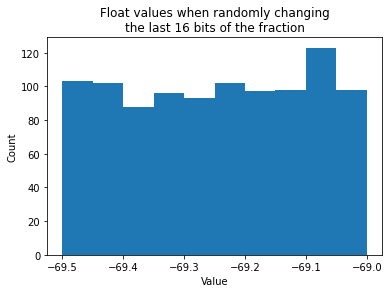

In [7]:
plt.hist(tmp)
plt.title(f"Float values when randomly changing\nthe last {k} bits of the fraction")
plt.xlabel("Value")
plt.ylabel("Count");

# "Hide" a string in a list of float values

In [8]:
# Test the string to bits and bits to string implementation
test_str: str = "I am Gabor, this is a test"
assert bits_to_str(str_to_bits(test_str)) == test_str, "Reconstructed is not the same string"

## Preparing the secret data/message

In [9]:
# Text we want to hide
s_to_hide = "I am Gabor and I want to add this secret to the model. Let's see how it goes, hopefully we can recover the message."

In [10]:
# The text converted to bits
s_bits = str_to_bits(s_to_hide)
print(f"Text to hide is {len(s_bits)} bits -- {len(s_bits)/8} bytes")

Text to hide is 920 bits -- 115.0 bytes


In [11]:
print(f"Text in bits:\n{''.join(map(str, s_bits))}")

Text in bits:
01001001001000000110000101101101001000000100011101100001011000100110111101110010001000000110000101101110011001000010000001001001001000000111011101100001011011100111010000100000011101000110111100100000011000010110010001100100001000000111010001101000011010010111001100100000011100110110010101100011011100100110010101110100001000000111010001101111001000000111010001101000011001010010000001101101011011110110010001100101011011000010111000100000010011000110010101110100001001110111001100100000011100110110010101100101001000000110100001101111011101110010000001101001011101000010000001100111011011110110010101110011001011000010000001101000011011110111000001100101011001100111010101101100011011000111100100100000011101110110010100100000011000110110000101101110001000000111001001100101011000110110111101110110011001010111001000100000011101000110100001100101001000000110110101100101011100110111001101100001011001110110010100101110


## Let's hide the secret

### Details about the data

In [12]:
# Bits to use from the fraction of the float value 
nb_bits_to_modify_from_fraction:int = 8
assert nb_bits_to_modify_from_fraction <= 23, "Number of bits can't be bigger the number of bits in the fraction"

In [13]:
# This is how many values are needed to hide and recover the hidden string
nb_vales_needed:int = math.ceil(len(s_bits) / nb_bits_to_modify_from_fraction)

In [14]:
print(f"(minimum) Number of floats needed: {nb_vales_needed} (32bit float values)")

(minimum) Number of floats needed: 115 (32bit float values)


In [15]:
# Randomly generated data what we can modify and hide the text by modifying float bits
# In a real life scenario this data is from the model weights
data = [random.uniform(-1, 1) for _ in range(nb_vales_needed)]

In [16]:
# Using only the last N bits of each float value
theoretical_max_hide_size = len(data) * nb_bits_to_modify_from_fraction
print(f"Theoretical max text size to hide is {theoretical_max_hide_size} bits - {theoretical_max_hide_size / 8} bytes")

Theoretical max text size to hide is 920 bits - 115.0 bytes


### Hiding mechanism

In [17]:
modified_data: List[float] = []

# We need to know the last modified value's index as the secret can be shorter then the data we are using to hide it
last_modified_index:int = -1

for i in range(nb_vales_needed):
    # Define the chunck of data to hide from the secret message bits
    _from_index = i * nb_bits_to_modify_from_fraction
    _to_index = _from_index + nb_bits_to_modify_from_fraction
    bits_to_hide = s_bits[_from_index:_to_index]
    bits_to_hide = list(map(bool, bits_to_hide))
    
    # Modify the current float value fraction bits
    x = FloatBinary(data[i])
    fraction_modified = list(x.fraction)
    fraction_modified[-nb_bits_to_modify_from_fraction:] = bits_to_hide
    x_modified = x.modify_clone(fraction=tuple(fraction_modified))
    modified_data.append(x_modified.v)
    
last_modified_index = i

### Inspect the changes in the float values

In [18]:
diff = np.array(modified_data) - np.array(data)
diff_abs = np.abs(diff)

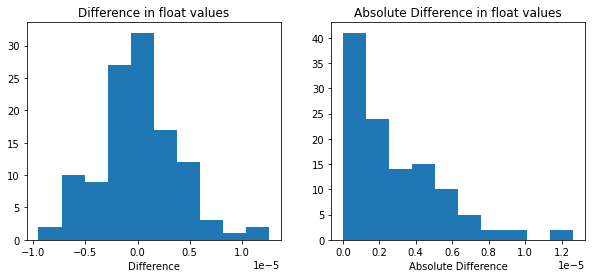

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(diff)
axs[0].set_title("Difference in float values")
axs[0].set_xlabel("Difference")

axs[1].hist(diff_abs)
axs[1].set_title("Absolute Difference in float values")
axs[1].set_xlabel("Absolute Difference");

In [20]:
print(f"Min diff: {diff_abs.min()}")
print(f"Max diff: {diff_abs.max()}")
print(f"Mean diff: {diff_abs.mean()}")

Min diff: 2.0890109642124344e-09
Max diff: 1.2646178535025143e-05
Mean diff: 2.8639375234277818e-06


## Recover the message from the modified data

In [21]:
hidden_data: List[bool] = []

for d in modified_data:
    # We can take each value and grab the last K bits from its fraction
    x = FloatBinary(d)
    hidden_bits = x.fraction[-nb_bits_to_modify_from_fraction:]
    hidden_data.extend(hidden_bits)

In [22]:
recovered_message: str = bits_to_str(list(map(int, hidden_data)))

In [23]:
print(f"Recovered string:\n'{recovered_message}'")

Recovered string:
'I am Gabor and I want to add this secret to the model. Let's see how it goes, hopefully we can recover the message.'


In [24]:
if recovered_message == s_to_hide:
    print("Successful secret hiding and recovery! 🥳")
else:
    print("Recovered message is not the same as the original one 🤨")

Successful secret hiding and recovery! 🥳
